## Notebook for SHAP analysis & corresponding plots

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, DataStructs, PandasTools, Fragments, rdMolDescriptors, Descriptors, rdDepictor, Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem.PandasTools import ChangeMoleculeRendering
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
import matplotlib.colors as mcolors
import seaborn as sns
import shap

In [ ]:
df = pd.read_csv('../../datasets/label_batch1-6_feat.csv') ## added the labeled data from the 6th iteration of suggestions to the labeled data from 4th iteration manually
df['solv_comb_sm'] = df['solv_comb_sm'].apply(lambda x: Chem.MolToSmiles(Chem.MolFromSmiles(x)))
df

,solv_comb_sm,salt_comb_sm,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,...,norm_capacity_14,norm_capacity_15,norm_capacity_16,norm_capacity_17,norm_capacity_18,norm_capacity_19,norm_capacity_20,norm_capacity_21,norm_capacity_22,norm_capacity_23
0,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
1,COCCOC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
2,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.022233,0.02168,0.022967,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
3,COCCOCC(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,...,0.000573,0.00046,0.000360,0.000407,0.0006,0.000593,0.000447,0.000333,0.0,0.0
4,CCOCCOC(C)(C)C,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,COC1CCCCC1=O,[Li+].F[P-](F)(F)(F)(F)F,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
195,COC1CCCCC1=O,[Li+].O=C1O[B-](F)(F)OC1=O,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
196,COCCS(=O)(=O)F,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.774656,-1.131648,1.061661,-0.391643,-0.188458,0.184919,0.733522,0.657518,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0
197,COCCSC,[Li+].[N-](S(=O)(=O)F)S(=O)(=O)F,-0.819883,-1.431011,0.956715,-0.464875,-0.484067,0.206120,0.691785,0.673957,...,0.000000,0.00000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0,0.0


In [ ]:
X = df.iloc[:,2:27]
y = df['norm_capacity_3']
X

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,salt_ecfp_pca_5,salt_ecfp_pca_6,salt_ecfp_pca_7,salt_ecfp_pca_8,salt_ecfp_pca_9,mol_wt_solv,mol_wt_salt,conc_salt_1,theor_capacity,amt_electrolyte
0,-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,-0.780469,-0.407588,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,90.068080,186.939685,1.0,150,50
1,-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,-0.507040,-0.352331,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,118.099380,186.939685,1.0,150,50
2,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,132.115030,186.939685,1.0,150,50
3,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,132.115030,186.939685,1.0,150,50
4,-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,0.099267,-0.130341,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,146.130680,186.939685,2.2,150,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,-0.924465,-0.769289,...,0.203690,-0.160053,0.195230,0.319099,-0.209425,128.083730,151.980186,1.0,150,50
195,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,-0.924465,-0.769289,...,-0.387958,-0.076666,0.008496,0.161338,0.109063,128.083730,144.001775,1.0,150,50
196,-0.774656,-1.131648,1.061661,-0.391643,-0.188458,0.184919,0.733522,0.657518,-1.061449,-0.608401,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,142.009993,186.939685,1.0,150,50
197,-0.819883,-1.431011,0.956715,-0.464875,-0.484067,0.206120,0.691785,0.673957,-0.907013,-0.467004,...,0.128733,-0.322339,0.258767,0.301779,-0.272648,106.045236,186.939685,1.0,150,50


In [22]:
std_scale_ = StandardScaler().fit(X)
X_std = std_scale_.transform(X)
X_std = pd.DataFrame(X_std, columns=X.columns)

### SHAP analysis

#### Model: 3 (RQ)

In [ ]:
# Load the pre-trained model
gpr = pickle.load(open('../../models/batch-7/rq_batch7.pkl', 'rb')) ## GPR model with Rational Quadratic (RQ) covariance kernel is the best performing model for batch 7

explainer = shap.KernelExplainer(gpr.predict, X)
shap_values_rq = explainer.shap_values(X)

In [6]:
blue = (0, 0.576, 0.902) # 0, 147, 230
green = (0.349,0.745,0.306) # 89, 190, 78
red = (0.984, 0.262, 0.219) # 251, 67, 56 
orange = (0.984, 0.713, 0.305) # 251, 182, 78 
purple = (0.839, 0.286, 0.604) # 214, 73, 1541
anvil = (0.298, 0.78, 0.77) # 76, 199, 196
dark_purple = (0.557, 0, 0.998) # 142, 0, 252
pink = (0.95, 0.78, 0.996) # 242, 199, 154
gray = (0.463,0.463,0.463) # 118, 118, 118

In [16]:
cols_X = X.columns
cols_shap = [('shap_' + cols_X[i]) for i in range(len(cols_X))]
shap_df = pd.DataFrame(shap_values_rq, columns=cols_shap)
shap_df

,shap_solv_ecfp_pca_0,shap_solv_ecfp_pca_1,shap_solv_ecfp_pca_2,shap_solv_ecfp_pca_3,shap_solv_ecfp_pca_4,shap_solv_ecfp_pca_5,shap_solv_ecfp_pca_6,shap_solv_ecfp_pca_7,shap_solv_ecfp_pca_8,shap_solv_ecfp_pca_9,...,shap_salt_ecfp_pca_5,shap_salt_ecfp_pca_6,shap_salt_ecfp_pca_7,shap_salt_ecfp_pca_8,shap_salt_ecfp_pca_9,shap_mol_wt_solv,shap_mol_wt_salt,shap_conc_salt_1,shap_theor_capacity,shap_amt_electrolyte
0,0.000000,0.000000,0.0,0.0,0.000009,0.000005,0.000021,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000473,-0.000052,-0.000006,-0.000071,-0.000014
1,0.000000,-0.000004,0.0,0.0,0.000029,-0.000016,0.000011,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000140,-0.000035,-0.000005,-0.000071,-0.000012
2,0.000000,0.000000,0.0,0.0,0.000031,-0.000015,0.000016,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000019,-0.000030,-0.000006,-0.000070,-0.000012
3,0.000000,0.000000,0.0,0.0,0.000031,-0.000014,0.000016,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000019,-0.000031,-0.000006,-0.000070,-0.000012
4,0.000000,0.000008,0.0,0.0,-0.000022,0.000000,0.000028,0.000000,0.0,-0.000007,...,0.0,0.0,0.0,0.0,0.0,-0.000077,-0.000028,0.000067,-0.000069,-0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,-0.000006,-0.000011,0.0,0.0,0.000008,0.000006,-0.000017,0.000012,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000056,0.000038,-0.000006,-0.000074,-0.000013
195,-0.000007,-0.000013,0.0,0.0,0.000008,0.000000,-0.000018,0.000012,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000057,0.000071,-0.000006,-0.000076,-0.000013
196,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000023,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,-0.000049,-0.000026,-0.000004,-0.000067,-0.000009
197,0.000000,0.000006,0.0,0.0,0.000013,0.000000,0.000020,0.000000,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.000270,-0.000043,0.000000,-0.000071,-0.000013


In [ ]:
comb_df = pd.concat([X, shap_df], axis=1)
comb_df

,solv_ecfp_pca_0,solv_ecfp_pca_1,solv_ecfp_pca_2,solv_ecfp_pca_3,solv_ecfp_pca_4,solv_ecfp_pca_5,solv_ecfp_pca_6,solv_ecfp_pca_7,solv_ecfp_pca_8,solv_ecfp_pca_9,...,shap_salt_ecfp_pca_5,shap_salt_ecfp_pca_6,shap_salt_ecfp_pca_7,shap_salt_ecfp_pca_8,shap_salt_ecfp_pca_9,shap_mol_wt_solv,shap_mol_wt_salt,shap_conc_salt_1,shap_theor_capacity,shap_amt_electrolyte
0,-0.845301,-0.995151,1.062720,-0.357552,-0.308720,0.309456,0.693325,0.613072,-0.780469,-0.407588,...,0.0,0.0,0.0,0.0,0.0,0.000473,-0.000052,-0.000006,-0.000071,-0.000014
1,-1.183255,-0.948338,0.615257,-0.582269,-1.010187,-0.522075,0.496896,0.301582,-0.507040,-0.352331,...,0.0,0.0,0.0,0.0,0.0,0.000140,-0.000035,-0.000005,-0.000071,-0.000012
2,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.0,0.0,0.0,0.0,0.0,0.000019,-0.000030,-0.000006,-0.000070,-0.000012
3,-1.240814,-0.970769,0.671105,-0.607789,-1.124651,-0.436617,0.628824,0.421934,-0.667954,-0.376857,...,0.0,0.0,0.0,0.0,0.0,0.000019,-0.000031,-0.000006,-0.000070,-0.000012
4,-0.879184,-1.539457,0.507075,-0.111830,0.800175,0.133053,0.926130,-0.208395,0.099267,-0.130341,...,0.0,0.0,0.0,0.0,0.0,-0.000077,-0.000028,0.000067,-0.000069,-0.000011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,-0.924465,-0.769289,...,0.0,0.0,0.0,0.0,0.0,0.000056,0.000038,-0.000006,-0.000074,-0.000013
195,0.996265,-0.567873,1.168385,-0.494515,-0.269926,0.307456,-0.150987,-0.613881,-0.924465,-0.769289,...,0.0,0.0,0.0,0.0,0.0,0.000057,0.000071,-0.000006,-0.000076,-0.000013
196,-0.774656,-1.131648,1.061661,-0.391643,-0.188458,0.184919,0.733522,0.657518,-1.061449,-0.608401,...,0.0,0.0,0.0,0.0,0.0,-0.000049,-0.000026,-0.000004,-0.000067,-0.000009
197,-0.819883,-1.431011,0.956715,-0.464875,-0.484067,0.206120,0.691785,0.673957,-0.907013,-0.467004,...,0.0,0.0,0.0,0.0,0.0,0.000270,-0.000043,0.000000,-0.000071,-0.000013


#### Figure 2(g) in main article

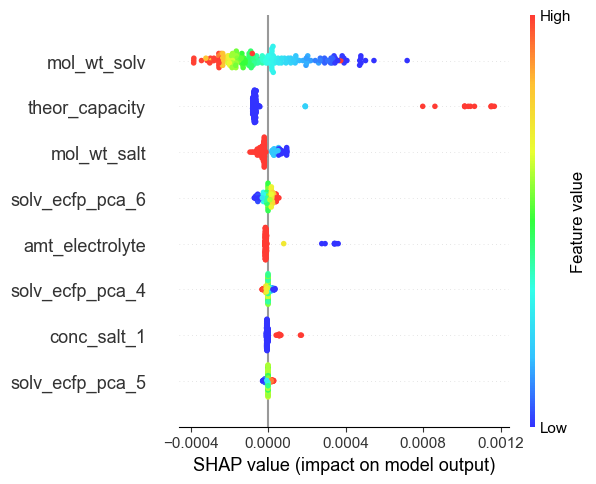

In [ ]:
# fig, ax = plt.subplots(figsize=(5.5, 6))
c1 = '#3333FF'; c1 = mcolors.to_rgb(c1)
c2 = '#33C2FF'; c2 = mcolors.to_rgb(c2)
c3 = '#33FFE8'; c3 = mcolors.to_rgb(c3)
c4 = '#33FF3B'; c4 = mcolors.to_rgb(c4)
c5 = '#E9FF33'; c5 = mcolors.to_rgb(c5)
c6 = '#FFC133'; c6 = mcolors.to_rgb(c6)
c7 = '#FF3B33'; c7 = mcolors.to_rgb(c7)
# cmap1_or = mcolors.LinearSegmentedColormap.from_list("", [c7,c6,c5,c4,c3,c2,c1]) ## from red to blue
cmap1 = mcolors.LinearSegmentedColormap.from_list("", [c1,c2,c3,c4,c5,c6,c7]) ## from blue to red

# Create the SHAP summary plot
shap.summary_plot(shap_values_rq, X, max_display=8, show=False, cmap=cmap1)

plt.xticks([-0.0004, 0.0, 0.0004, 0.0008, 0.0012])
# Adjust the figure size
plt.gcf().set_size_inches(5.5, 5)

#### Figure S14(a) in SI

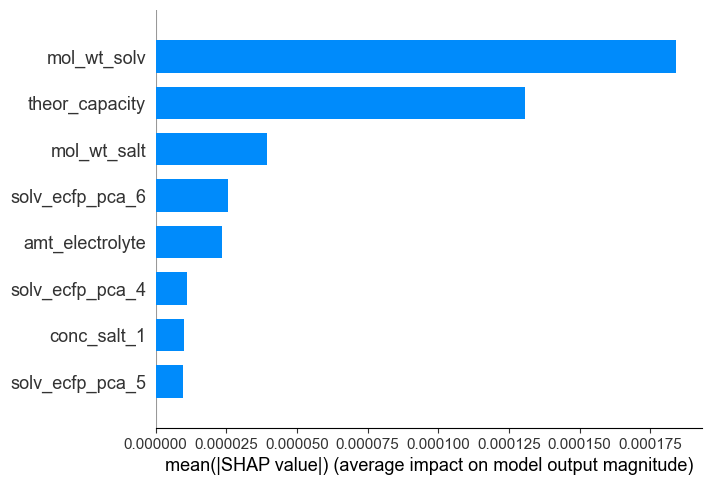

In [ ]:
# fig, ax = plt.subplots(figsize=(6, 5))
shap.summary_plot(shap_values_rq, X, max_display=8, plot_type='bar', cmap=cmap1, show=False)
plt.gcf().set_size_inches(7, 5)

#### Figure S14(c) in SI

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


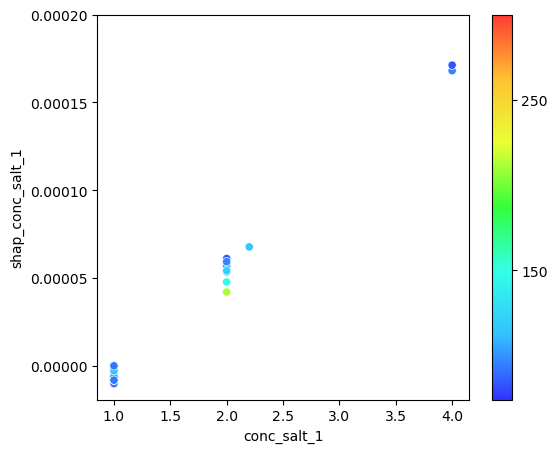

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='conc_salt_1', y='shap_conc_salt_1', data=comb_df, hue='mol_wt_solv', palette=cmap1)
# norm = plt.Normalize(comb_df['mol_wt_solv'].min(), comb_df['mol_wt_solv'].max())
norm = plt.Normalize(comb_df['mol_wt_solv'].min(), 300)
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.set_yticks([0.0,0.00005, 0.00010,0.00015,0.00020])
# ax.figure.colorbar(sm, ticks=[150, 250, 350, 450])
ax.figure.colorbar(sm, ticks=[150, 250, 350, 450]) ## only till 300 and not max value of 'mol_wt_solv' (next plot)
# ax.figure.colorbar(sm)

#### Figure S14(b) in SI

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


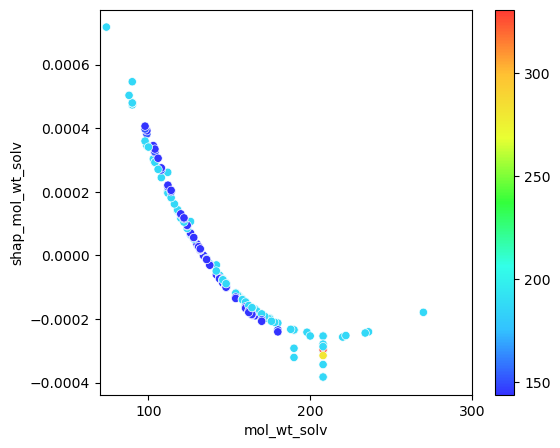

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='mol_wt_solv', y='shap_mol_wt_solv', data=comb_df, hue='mol_wt_salt', palette=cmap1)
# ax = sns.scatterplot(x='mol_wt_solv', y='shap_mol_wt_solv', data=comb_df, hue='conc_salt_1', palette=cmap1)
norm = plt.Normalize(comb_df['mol_wt_salt'].min(), comb_df['mol_wt_salt'].max())
# norm = plt.Normalize(comb_df['conc_salt_1'].min(), comb_df['conc_salt_1'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)
sm.set_array([])

ax.set_xlim(70, 300)
ax.set_xticks([100, 200, 300]) ## only till 300 and not max value of 'mol_wt_solv' (keeps on increasing which does not make sense)
# Remove the legend and add a colorbar
ax.get_legend().remove()
# ax.set_yticks([-2, -1, 0, 1])
ax.figure.colorbar(sm, ticks=[100, 150, 200, 250, 300])
# ax.figure.colorbar(sm, ticks=[1, 2, 3, 4])
# ax.figure.colorbar(sm)

In [112]:
comb_df = comb_df.sort_values(by='solv_ecfp_pca_8', ascending=False)

#### Figure S14(d) in SI

Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.


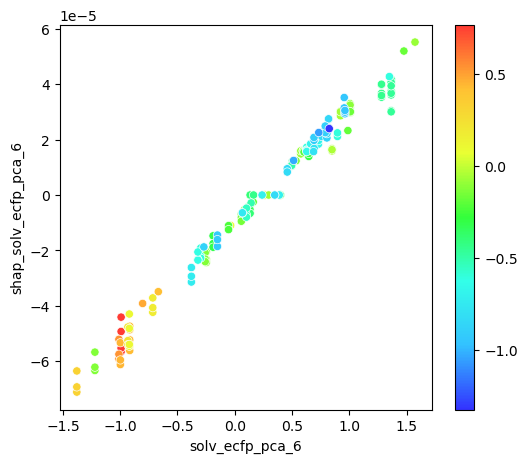

In [ ]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.scatterplot(x='solv_ecfp_pca_6', y='shap_solv_ecfp_pca_6', data=comb_df, hue='solv_ecfp_pca_8', palette=cmap1)
norm = plt.Normalize(comb_df['solv_ecfp_pca_8'].min(), comb_df['solv_ecfp_pca_8'].max())
sm = plt.cm.ScalarMappable(cmap=cmap1, norm=norm)

# Remove the legend and add a colorbar
ax.get_legend().remove()
ax.figure.colorbar(sm, ticks=[-1, -0.5, 0, 0.5])
# ax.figure.colorbar(sm)

### Generate molecular substructures corresponding to ECFP fingerprints

In [ ]:
# Function to get the substructures corresponding to ECFP bits -> from copilot
def get_ecfp_substructures(smiles, radius=2, n_bits=1024):
    mol = Chem.MolFromSmiles(smiles)
    info = {}
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits, bitInfo=info)
    
    substructures = {}
    for bit, paths in info.items():
        substructures[bit] = []
        for path in paths:
            env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, path[0])
            amap = {}
            submol = Chem.PathToSubmol(mol, env, atomMap=amap)
            substructures[bit].append(Chem.MolToSmiles(submol))
    return substructures

# 1. Prepare your list of SMILES
# smiles_list = ['CCO', 'CCN', 'CCC', 'CCCl', 'CCBr']
smiles_list = list(df['solv_comb_sm'].unique())

# 2. Initialize data structures to store results
molecules = []
fingerprints = []
bitInfos = []
invalid_smiles = []

# 3. Iterate over the list of SMILES
for smiles in smiles_list:
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        print(f"SMILES '{smiles}' could not be parsed.")
        invalid_smiles.append(smiles)
        continue
    molecules.append(mol)
    
    # Generate Morgan fingerprint with bit information
    bitInfo = {}
    # fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048, bitInfo=bitInfo)
    fingerprint = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024, bitInfo=bitInfo) ## 1024 bit size was used for reducing ECFP to 10 features using PCA
    fingerprints.append(fingerprint)
    bitInfos.append(bitInfo)

# 4. Function to visualize substructures corresponding to bits
def visualize_bit_substructures(mol, bitInfo, bit_id):
    highlighted_atoms = set()
    for atom_idx, radius in bitInfo[bit_id]:
        env = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_idx)
        atoms = set()
        if not env:  # Handle single atom case
            atoms.add(atom_idx)
        else:
            for bond_id in env:
                bond = mol.GetBondWithIdx(bond_id)
                atoms.add(bond.GetBeginAtomIdx())
                atoms.add(bond.GetEndAtomIdx())
        highlighted_atoms.update(atoms)
    
    # Draw the molecule with highlighted atoms
    mol_copy = Chem.Mol(mol)
    drawer = Draw.MolDraw2DCairo(300, 300)
    opts = drawer.drawOptions()
    # Highlight the atoms in red
    opts.atomHighlights = {idx: (1, 0, 0) for idx in highlighted_atoms}
    drawer.DrawMolecule(mol_copy, highlightAtoms=highlighted_atoms)
    drawer.FinishDrawing()
    img = drawer.GetDrawingText()
    return img, highlighted_atoms

# 5. Map bits back to substructures for each molecule
for i, mol in enumerate(molecules):
    smiles = smiles_list[i]
    bitInfo = bitInfos[i]
    print(f"\nProcessing Molecule: {smiles}")
    
    # Get the bits that are set in the fingerprint
    on_bits = fingerprints[i].GetOnBits()
    print(f"Number of bits set: {len(on_bits)}")
    
    # For demonstration, process each bit
    for bit_id in on_bits:
        # Visualize the substructure corresponding to this bit
        img, highlighted_atoms = visualize_bit_substructures(mol, bitInfo, bit_id)
        print(f"  Bit ID: {bit_id}, Highlighted Atoms: {highlighted_atoms}")
        # Save the image to a file
        with open(f"substructures/{smiles}_bit_{bit_id}.png", 'wb') as f:
            f.write(img)
        # Optionally, add more code to analyze or process the substructures


Processing Molecule: COCCOC
Number of bits set: 8
  Bit ID: 13, Highlighted Atoms: {1, 2, 3, 4}
  Bit ID: 33, Highlighted Atoms: {0, 5}
  Bit ID: 80, Highlighted Atoms: {2, 3}
  Bit ID: 486, Highlighted Atoms: {0, 1, 2, 3, 4, 5}
  Bit ID: 695, Highlighted Atoms: {1, 4}
  Bit ID: 841, Highlighted Atoms: {0, 1, 4, 5}
  Bit ID: 893, Highlighted Atoms: {0, 1, 2, 3, 4, 5}
  Bit ID: 1005, Highlighted Atoms: {0, 1, 2, 3, 4, 5}

Processing Molecule: COCCOC(C)C
Number of bits set: 15
  Bit ID: 1, Highlighted Atoms: {5}
  Bit ID: 13, Highlighted Atoms: {1, 2, 3, 4}
  Bit ID: 33, Highlighted Atoms: {0, 6, 7}
  Bit ID: 80, Highlighted Atoms: {2, 3}
  Bit ID: 283, Highlighted Atoms: {5, 6, 7}
  Bit ID: 316, Highlighted Atoms: {3, 4, 5}
  Bit ID: 331, Highlighted Atoms: {3, 4, 5, 6, 7}
  Bit ID: 457, Highlighted Atoms: {2, 3, 4, 5, 6, 7}
  Bit ID: 486, Highlighted Atoms: {0, 1, 2, 3}
  Bit ID: 520, Highlighted Atoms: {1, 2, 3, 4, 5}
  Bit ID: 695, Highlighted Atoms: {1, 4}
  Bit ID: 841, Highlighte

#### Plot to show number of molecules having three important substructures: Figure 2(i) in main article

In [25]:
with open('substructures/114bit_sub6', 'r') as f1:
    array_sub6 = []
    for line in f1.readlines():
        # print(line)
        array_sub6.append(line.split('_')[0])
f1.close()

with open('substructures/841bit_sub4', 'r') as f2:
    array_sub4 = []
    for line in f2.readlines():
        # print(line)
        array_sub4.append(line.split('_')[0])
f2.close()

with open('substructures/1bit_sub5', 'r') as f3:
    array_sub5 = []
    for line in f3.readlines():
        # print(line)
        array_sub5.append(line.split('_')[0])
f3.close()

In [ ]:
df_finger_sub6 = df.query('solv_comb_sm == {}'.format(array_sub6))[['solv_comb_sm', 'norm_capacity_3', 'rq_norm_capacity_3']]
df_finger_sub6

,solv_comb_sm,norm_capacity_3,rq_norm_capacity_3
4,CCOCCOC(C)(C)C,0.026187,0.399959
11,FC(F)(F)COCCOCCOCC(F)(F)F,0.366900,0.270248
13,COCCOCC(F)(F)C(F)(F)F,0.652767,0.476053
14,COCCOCC(F)(F)C(F)(F)F,0.770547,0.476053
15,COCCOCC(F)(F)C(F)(F)F,0.700847,0.476053
16,FC(F)(F)COCCOCCOCCOCC(F)(F)F,0.477793,0.399980
17,COCCOCC(F)(F)C(F)(F)F,0.751720,0.476053
18,COCCOCC(F)(F)C(F)(F)F,0.684840,0.476053
20,COCCOCC(F)(F)C(F)F,0.816787,0.434430
21,COCCOCC(F)(F)C(F)F,0.691613,0.434430


In [ ]:
df_finger_sub4 = df.query('solv_comb_sm == {}'.format(array_sub4))[['solv_comb_sm', 'norm_capacity_3', 'rq_norm_capacity_3']]
df_finger_sub4

,solv_comb_sm,norm_capacity_3,rq_norm_capacity_3
0,COCCOC,0.276580,0.356559
1,COCCOC(C)C,0.661460,0.265441
2,COCCOCC(C)C,0.178387,0.289472
3,COCCOCC(C)C,0.216953,0.289472
7,CCCCOCCOC,0.285020,0.404838
...,...,...,...
194,COC1CCCCC1=O,0.000000,0.158539
195,COC1CCCCC1=O,0.000000,0.151038
196,COCCS(=O)(=O)F,0.264730,0.348684
197,COCCSC,0.000000,0.361483


In [ ]:
df_finger_sub5 = df.query('solv_comb_sm == {}'.format(array_sub5))[['solv_comb_sm', 'norm_capacity_3', 'rq_norm_capacity_3']]
df_finger_sub5

,solv_comb_sm,norm_capacity_3,rq_norm_capacity_3
1,COCCOC(C)C,0.661460,0.265441
2,COCCOCC(C)C,0.178387,0.289472
3,COCCOCC(C)C,0.216953,0.289472
5,CCOCCOC(C)C,0.620447,0.438206
6,CCOCCOC(C)C,0.643713,0.438206
9,CCCCOCCOC(C)C,0.566000,0.408122
20,COCCOCC(F)(F)C(F)F,0.816787,0.434430
21,COCCOCC(F)(F)C(F)F,0.691613,0.434430
39,COCCOCC(F)(F)C(F)F,0.612006,0.484402
40,COCCOCC(F)(F)C(F)F,0.642517,0.510664


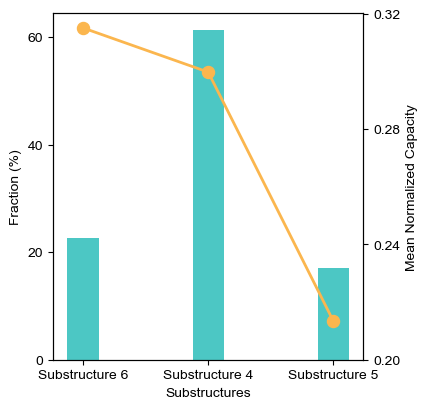

In [ ]:
frac_sub = [len(array_sub6) / len(df_['solv_comb_sm'].unique()), len(array_sub4) / len(df_['solv_comb_sm'].unique()), len(array_sub5) / len(df_['solv_comb_sm'].unique())]
frac_sub = [i*100 for i in frac_sub]
norm_cap_sub = [df_finger_sub6['norm_capacity_3'].mean(), df_finger_sub4['norm_capacity_3'].mean(), df_finger_sub5['norm_capacity_3'].mean()]
fig, ax = plt.subplots(figsize=(4, 4.5))
# ax = sns.barplot(x=['Substructure 6', 'Substructure 4', 'Substructure 5'], y=frac_sub, palette='viridis')
plt.bar(['Substructure 6', 'Substructure 4', 'Substructure 5'], frac_sub, color=anvil, width=0.25)
ax2 = ax.twinx()
ax2.scatter(['Substructure 6', 'Substructure 4', 'Substructure 5'], norm_cap_sub, color=orange, marker='o', s=75)
ax2.plot(['Substructure 6', 'Substructure 4', 'Substructure 5'], norm_cap_sub, color=orange, marker=None, linewidth=2)
ax2.set_yticks([0.20, 0.24, 0.28, 0.32])
ax.set_yticks([0, 20, 40, 60])
ax.set_ylabel('Fraction (%)')
ax2.set_ylabel('Mean Normalized Capacity')
ax.set_xlabel('Substructures')
# ax.set_title('Fraction of Substructures')